In [1]:
!pip install mlem torchvision tensorflow numpy --upgrade
!pip install mlem==0.4.6 --no-deps
!pip install iterative-telemetry==0.0.7 --ignore-requires-python --no-deps
!pip install pydantic==1.10.2 --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.5/218.5 kB 4.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 40.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.1/218.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.3/216.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.5/214.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.8/213.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━

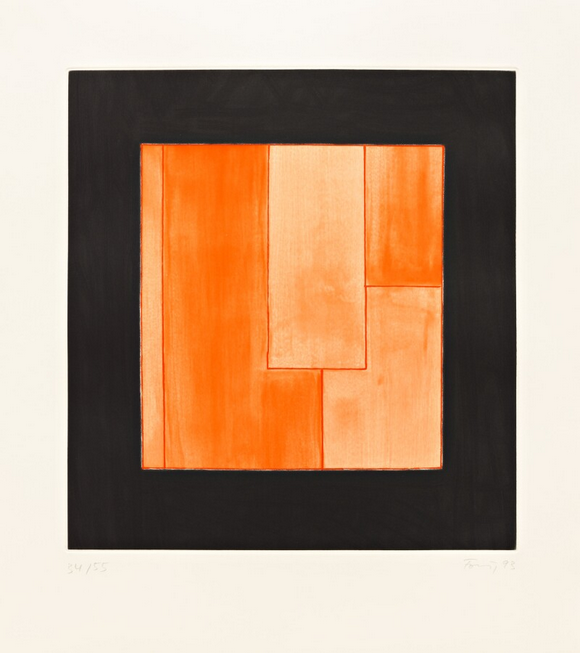

In [2]:
from PIL import Image

Image.open("/kaggle/input/art-price-dataset/artDataset/image_10.png")

In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/art-price-dataset/artDataset.csv")
df["image"] = [f'image_{i}.png' for i in range(1, len(df) + 1)]
df.head()

,Unnamed: 0,price,artist,title,yearCreation,signed,condition,period,movement,image
0,0,28.500 USD,Tommaso Ottieri,Bayreuth Opera,2021,Signed on verso,This work is in excellent condition.,Contemporary,Baroque,image_1.png
1,1,3.000 USD,Pavel Tchelitchew,Drawings of the Opera,First Half 20th Century,Signed and titled,Not examined out of frame.No obvious signs of ...,Post-War,Surrealism,image_2.png
2,2,5.000 USD,Leo Gabin,Two on Sidewalk,2016,"Signed, titled and dated on verso",This work is in excellent condition.,Contemporary,Abstract,image_3.png
3,3,5.000 USD,Matthias Dornfeld,Blumenszene,2010,"Signed, titled and dated on the reverse with t...",This work is in excellent condition.There is m...,Contemporary,Abstract,image_4.png
4,4,2.500 USD,Alexis Marguerite Teplin,Feverish Embarkation,2001,Signed on verso,This work is in excellent condition.,Contemporary,Abstract,image_5.png


In [4]:
import os

images = list(os.walk("/kaggle/input/art-price-dataset/artDataset"))[0][2]
prices = df.set_index("image").loc[images].price.map(lambda x: int(x.strip(" USD").replace(".", ""))).values

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

images_arrays = []
for i in images:
    img = load_img(f"/kaggle/input/art-price-dataset/artDataset/{i}",target_size=(256,256))
    images_arrays.append(img_to_array(img))
    
    
images_arrays = np.concatenate([i.reshape(1, 256,256, 3) for i in images_arrays])
images_arrays.shape

(754, 256, 256, 3)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small, EfficientNetV2L, NASNetMobile
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocess_input



# Load the ResNet50 model
#base_model = MobileNetV3Small(include_top=False, input_shape=(256, 256, 3))
#base_model = EfficientNetV2L(include_top=False, input_shape=(256, 256, 3))
base_model = NASNetMobile(include_top=False, input_shape=(256, 256, 3))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=50,
                                           restore_best_weights=True)
#sv_model = tf.keras.callbacks.ModelCheckpoint(model_fn, save_best_only=True, monitor='val_mean_squared_logarithmic_error')
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.9)

# Create a new model on top
inputs = keras.Input(shape=(256, 256, 3))
x = nasnet_preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.AveragePooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(x)
x = keras.layers.Dense(256,kernel_regularizer='l2',activation='tanh')(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(256,kernel_regularizer='l1',activation='sigmoid')(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

# Freeze the base_model
base_model.trainable = False

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.13)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error',
                                                                      'mean_squared_error'])
# val loss don't go less than 6700
# but, the constant loss is 12800
# np.mean((prices - np.mean(prices)) ** 2) ** 0.5

# Train the model on your regression dataset
history = model.fit(images_arrays, np.log10(prices), epochs=200, validation_split=0.1, callbacks=[callback, lr_callback])

best_score = min(history.history['val_mean_squared_error'])
best_epoch = history.history['val_mean_squared_error'].index(best_score)
print(f"best epoch {best_epoch+1}  val_RMSLE: {best_score}")
print("metrics:")
print(f"Train MAE: {history.history['mean_absolute_error'][best_epoch]:.2f}    Train RMSLE: {history.history['mean_squared_error'][best_epoch]:.5f}")
print(f"val MAE: {history.history['val_mean_absolute_error'][best_epoch]:.2f}    val RMSLE: {history.history['val_mean_squared_error'][best_epoch]:.5f}")

Epoch 1/200


2023-04-14 08:38:48.886542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


22/22 [==============================] - 24s 384ms/step - loss: 303.9130 - mean_absolute_error: 2.1440 - mean_squared_error: 16.7384 - val_loss: 295.1255 - val_mean_absolute_error: 0.4524 - val_mean_squared_error: 0.3186 - lr: 0.1300
Epoch 2/200
22/22 [==============================] - 2s 85ms/step - loss: 240.7695 - mean_absolute_error: 0.6762 - mean_squared_error: 0.8293 - val_loss: 174.7961 - val_mean_absolute_error: 0.5386 - val_mean_squared_error: 0.5544 - lr: 0.1300
Epoch 3/200
22/22 [==============================] - 2s 93ms/step - loss: 134.8552 - mean_absolute_error: 0.7571 - mean_squared_error: 0.8968 - val_loss: 90.6395 - val_mean_absolute_error: 2.2842 - val_mean_squared_error: 5.5669 - lr: 0.1300
Epoch 4/200
22/22 [==============================] - 2s 84ms/step - loss: 347.5271 - mean_absolute_error: 2.0069 - mean_squared_error: 12.9372 - val_loss: 403.4568 - val_mean_absolute_error: 0.8428 - val_mean_squared_error: 0.9120 - lr: 0.1300
Epoch 5/200
22/22 [==================

In [26]:
best_score = min(history.history['val_mean_squared_logarithmic_error'])

history.history['val_mean_squared_logarithmic_error'].index(best_score)

50

In [9]:
preds = model.predict(images_arrays)
preds.shape

24/24 [==============================] - 7s 78ms/step


(754, 1)

In [ ]:
np.nanmean((y_true-y_pred)**2)**0.5

In [30]:
def rmsle(y_true, y_pred):
    return np.nanmean((np.log10(y_true) - np.log10(y_pred)) ** 2) ** 0.5

rmsle(prices,preds)

0.629311068304152

In [19]:
np.nanmean((np.log10(prices)-preds)**2)**0.5

0.5195541696963281

In [30]:
np.nanmean((np.log10(prices)-np.log10(np.median(prices)))**2)**0.5

0.5246660774915597

In [22]:
np.min(10**preds)

2694.535

(array([ 47.,  90., 111.,  84.,  59.,  54.,  56.,  93., 116.,  44.]),
 array([3.4304838, 3.4364457, 3.4424078, 3.44837  , 3.4543319, 3.4602938,
        3.466256 , 3.472218 , 3.47818  , 3.4841418, 3.490104 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

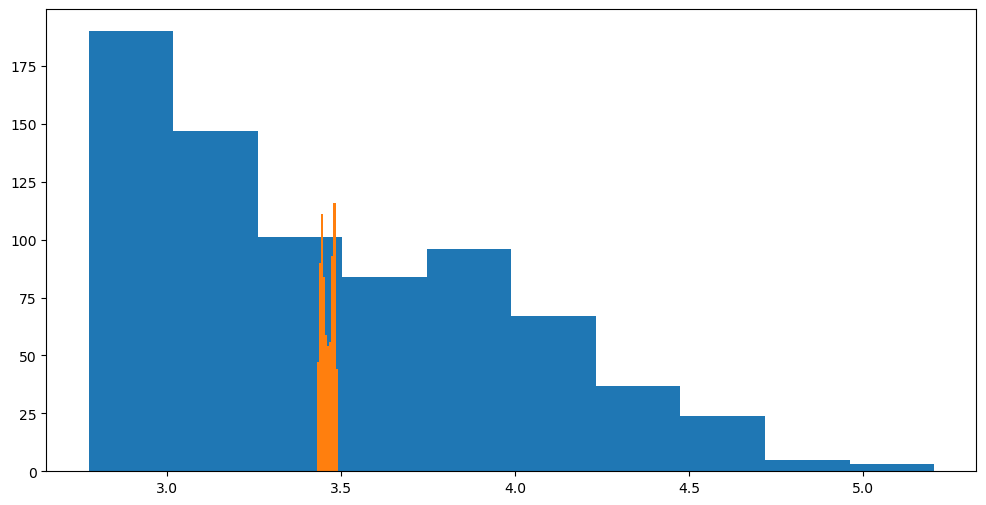

In [11]:
import numpy as np
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(np.log10(prices))
plt.hist(preds)

In [18]:
from mlem.api import save
img = img_to_array(Image.open("/kaggle/input/art-price-dataset/artDataset/image_1.png"))
save(
    model, 
    "/kaggle/working/models/nasnetmobile_2_dense_layers", 
    preprocess=lambda x: np.expand_dims(x[:256,:256,:3], 0),
    sample_data=img,
);

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......average_pooling2d
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............activation_10
...............vars
............activation_100
...............vars
............activation_101
...............vars
............activation_102
...............vars
............activation_103
...............vars
............activation_104
...............vars
............activation_105
...............vars
............activation_106
...............vars
............activation_107
...............vars
............activation_108
...............vars
............activation_109
...............vars
............activation_11